In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
from lmphoton.simulation import current_simulation as sim
from scipy.optimize import minimize
from vernier_ring import Ring
from sagnac_mirror import SagnacRing
from simple_soa import SOA
from scipy.constants import constants
import pandas as pd
import seaborn as sns
plt.style.use("plot_style.mplstyle")
warnings.filterwarnings("ignore")

In [2]:
um = 1e-6

no_bins = 500001

## Vernier ring design

In [3]:
_ring_1 = Ring(
    splitratio1=0.2,
    splitratio2=0.2,
    radius=25,
    waveguide_loss_rate=0.33,
    index=1
)

_ring_2 = Ring(
    splitratio1=0.2,
    splitratio2=0.2,
    radius=26.4,
    waveguide_loss_rate=0.33,
    index=2
)

_sagnac_ring = SagnacRing(
  loss = 0,
  waveguide_loss_rate=0,
  splitratio=0.5,
  index = 1
)

_ring_1_effective_length = _ring_1.get_effective_length()
_ring_2_effective_length = _ring_2.get_effective_length()
_sagnac_ring_effective_length = _sagnac_ring.get_effective_length()

print(f"Ring 1 effective length: {_ring_1_effective_length*1e6:0.3f} um,  Ring 2 effective length: {_ring_2_effective_length*1e6:0.3f} um, Sagnac effective length: {_sagnac_ring_effective_length*1e6:0.3f} um")

Ring 1 effective length: 628.319 um,  Ring 2 effective length: 663.504 um, Sagnac effective length: 251.327 um


In [4]:
def vernier_ring_tuning(phase, wavelength = 1.31e-6):
    """
    Objective function for tuning the vernier ring
    """

    _ring_1.wg1._init_phase = phase[0]
    _ring_2.wg2._init_phase = phase[1]
    _ring_1.recursive_update()
    _ring_2.recursive_update()
    sim().wavelength = wavelength
    _ring_1_smatrix = _ring_1.smatrix
    _ring_2_smatrix = _ring_2.smatrix

    _vernier_ring_smatrix = _ring_1_smatrix * _ring_2_smatrix
    return -np.abs(_vernier_ring_smatrix[0, 1])**2

def sagnac_ring_tuning(split_ratio = 0.707, wavelength = 1.31e-6):
    """
    Objective function for tuning the sagnac ring
    """
    _sagnac_ring.dc._splitratio = split_ratio
    _sagnac_ring.recursive_update()

    sim().wavelength = wavelength
    _sagnac_ring_smatrix = _sagnac_ring.smatrix

    return -np.abs(_sagnac_ring_smatrix[0, 0])**2

bounds = [(-np.pi, np.pi), (-np.pi, np.pi)]

opts = {
  "maxiter": 1000,
  "xatol": 1e-6,
  "fatol": 1e-6,
}

result = minimize(
    vernier_ring_tuning,
    ((0.0, 0.0)),
    bounds=bounds,
    method='Nelder-Mead',
    tol = 1e-6
    )

100%|██████████| 500001/500001 [02:19<00:00, 3591.01it/s]


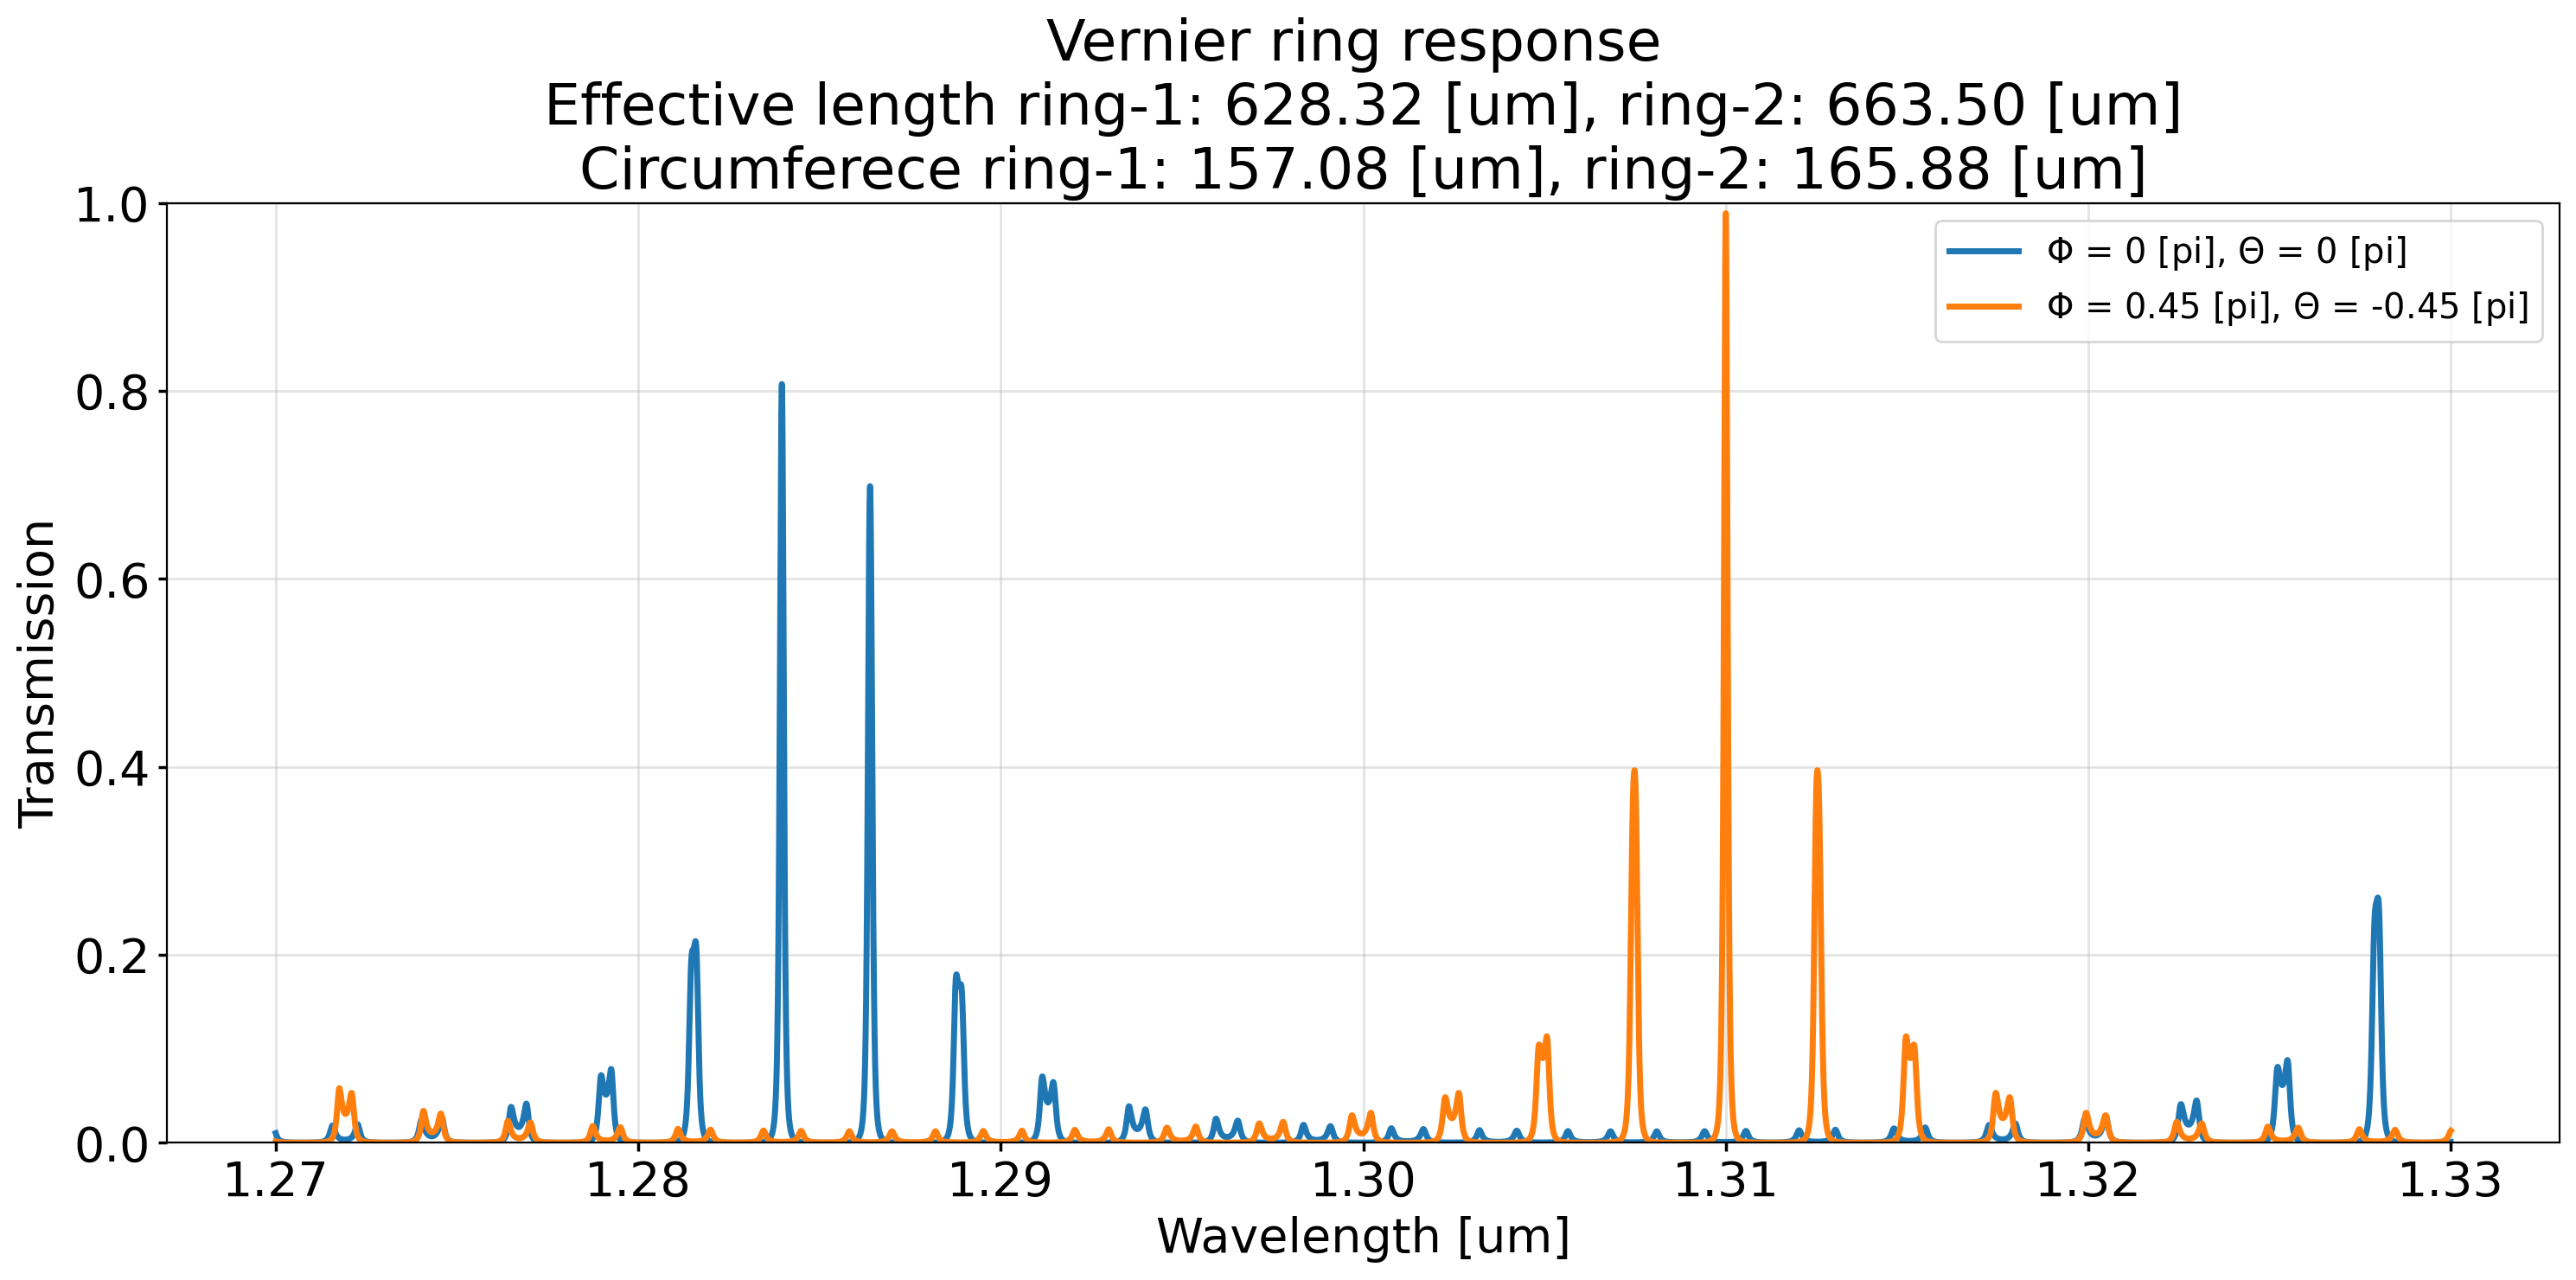

In [5]:
result.x
vernier_response_untuned = []
vernier_response_tuned = []
plt.figure(figsize=(15,7.5))
wavelengths = np.linspace(1.27, 1.33, num=no_bins) * um
for wavelength in tqdm(wavelengths):
  vernier_response_untuned.append(vernier_ring_tuning((0.0, 0.0), wavelength))
  vernier_response_tuned.append(vernier_ring_tuning((result.x[0], result.x[1]), wavelength))
plt.plot(wavelengths/um, -1*np.array(vernier_response_untuned), label=f"$\Phi$ = 0 [pi], $\Theta$ = 0 [pi]")
plt.plot(wavelengths/um, -1*np.array(vernier_response_tuned), label=f"$\Phi$ = {result.x[0]/np.pi:0.2f} [pi], $\Theta$ = {result.x[1]/np.pi:0.2f} [pi]")
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")
plt.title("Vernier ring response " +"\n"+f"Effective length ring-1: {_ring_1.get_effective_length()*1e6:0.2f} [um], ring-2: {_ring_2.get_effective_length()*1e6:0.2f} [um]" +"\n"+f"Circumferece ring-1: {_ring_1.L_circum*1e6:0.2f} [um], ring-2: {_ring_2.L_circum*1e6:0.2f} [um]")
plt.grid(True)
plt.ylim([0,1])
plt.legend()
plt.tight_layout()

## Longitudinal mode design

In [6]:
R_vrng = -1*vernier_ring_tuning((result.x[0], result.x[1]), 1.31e-6)
R_sagnac = -1*sagnac_ring_tuning(split_ratio=0.44, wavelength=1.31e-6)

T_vrng = 1 - R_vrng
T_sagnac = 1 - R_sagnac

print(f"Vernier ring reflectivity: {R_vrng:0.3f}, Sagnac ring reflectivity: {R_sagnac:0.3f}")
print(f"Vernier ring transmittivity: {T_vrng:0.3f}, Sagnac ring transmittivity: {T_sagnac:0.3f}")

Vernier ring reflectivity: 0.989, Sagnac ring reflectivity: 0.986
Vernier ring transmittivity: 0.011, Sagnac ring transmittivity: 0.014


In [7]:
def longitudinal_cavity_modes(L_soa = 1300*um, L_htr = 1300*um, L_excess = 250 * um, R_vrng = 0.9, R_sagnac=0.9, wavelength = 1.31e-6):
    """
    Calculate the longitudinal cavity modes
    """

    T_vrng = 1 - R_vrng
    T_sagnac = 1 - R_sagnac

    L_cavity = L_soa * 2 + L_htr * 2 + L_excess * 2 + _ring_1_effective_length + _ring_2_effective_length + _sagnac_ring_effective_length

    phi_offset = 2 * np.pi * L_cavity * 0.5 * 1.93 / 1.31e-6
    phi = 2 * np.pi * L_cavity * 0.5 * 1.93 / wavelength - phi_offset

    num = -1 * np.sqrt(T_vrng*T_sagnac) *  np.exp(-1j * phi)
    denom = 1 - np.sqrt(R_vrng*R_sagnac) * np.exp(-2 * 1j * phi)
    H = num/denom
    return np.real(H * np.conj(H))

100%|██████████| 500001/500001 [00:01<00:00, 323043.62it/s]


Text(0.5, 1.0, 'Longitudinal cavity modes')

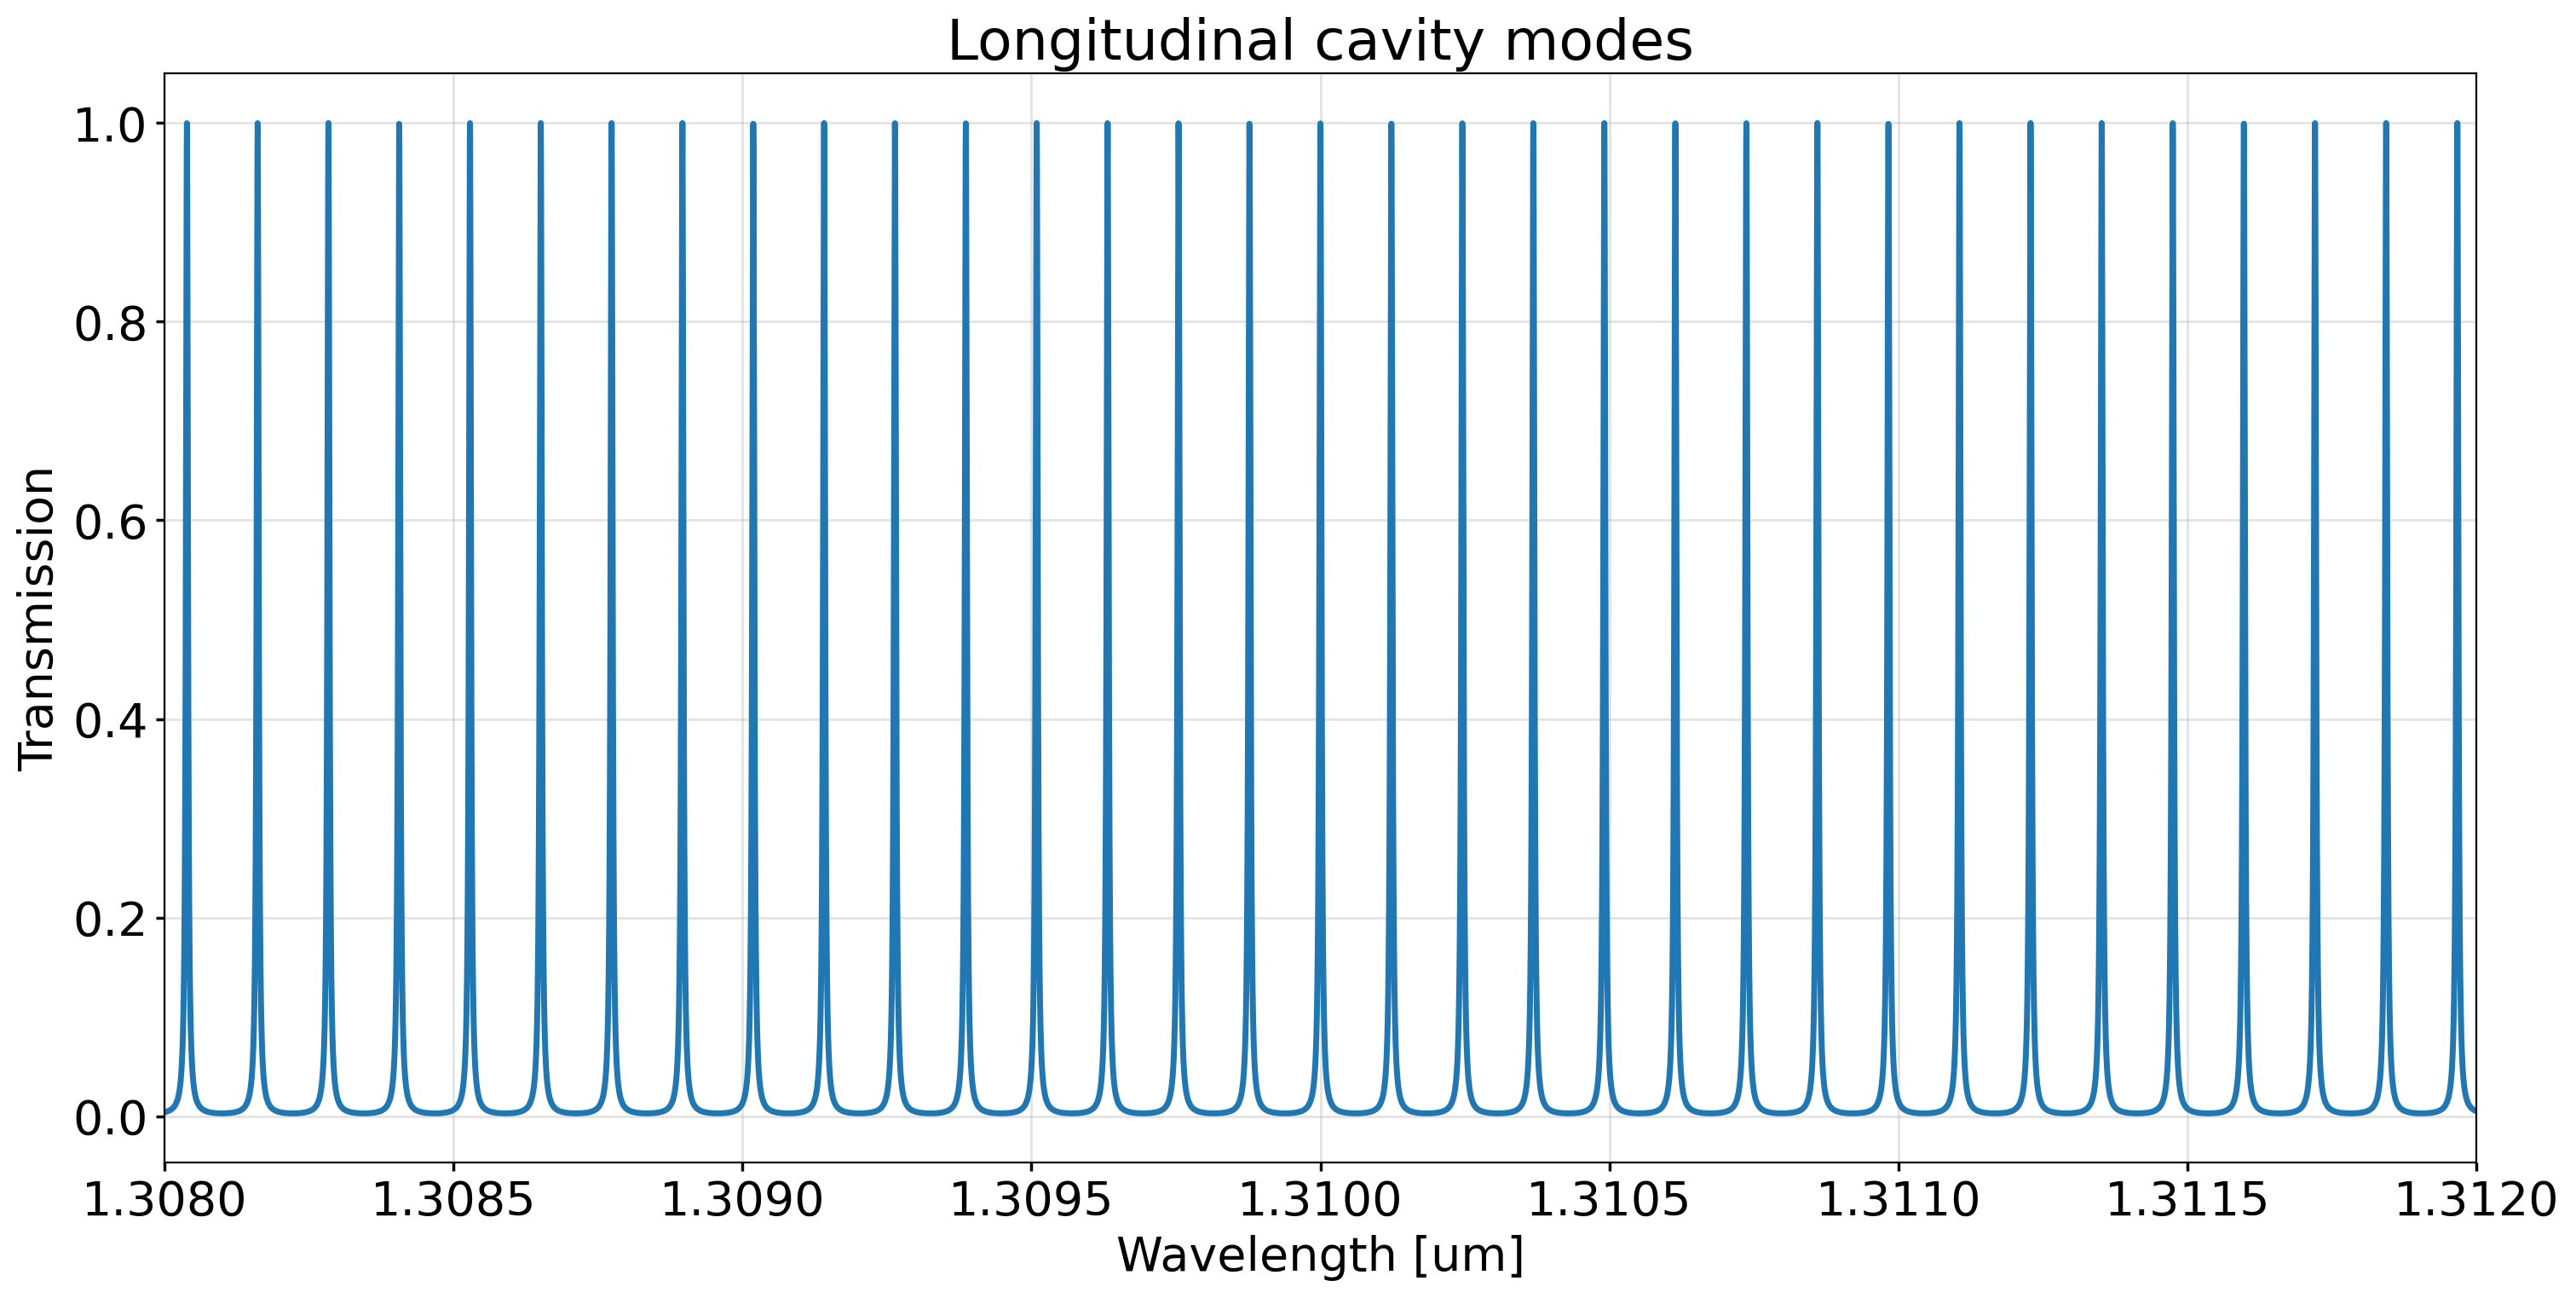

In [8]:
plt.figure(figsize=(15,7.5))
lc_modes = []
for wavelength in tqdm(wavelengths):
  lc_modes.append(longitudinal_cavity_modes(wavelength=wavelength))
plt.plot(wavelengths/um, lc_modes)
plt.xlim([1.308, 1.312])
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")
plt.title("Longitudinal cavity modes")

In [9]:
lc_modes = np.array(lc_modes)
laser_cavity_mode = lc_modes * -1*np.array(vernier_response_tuned)

Text(0, 0.5, 'Transmission')

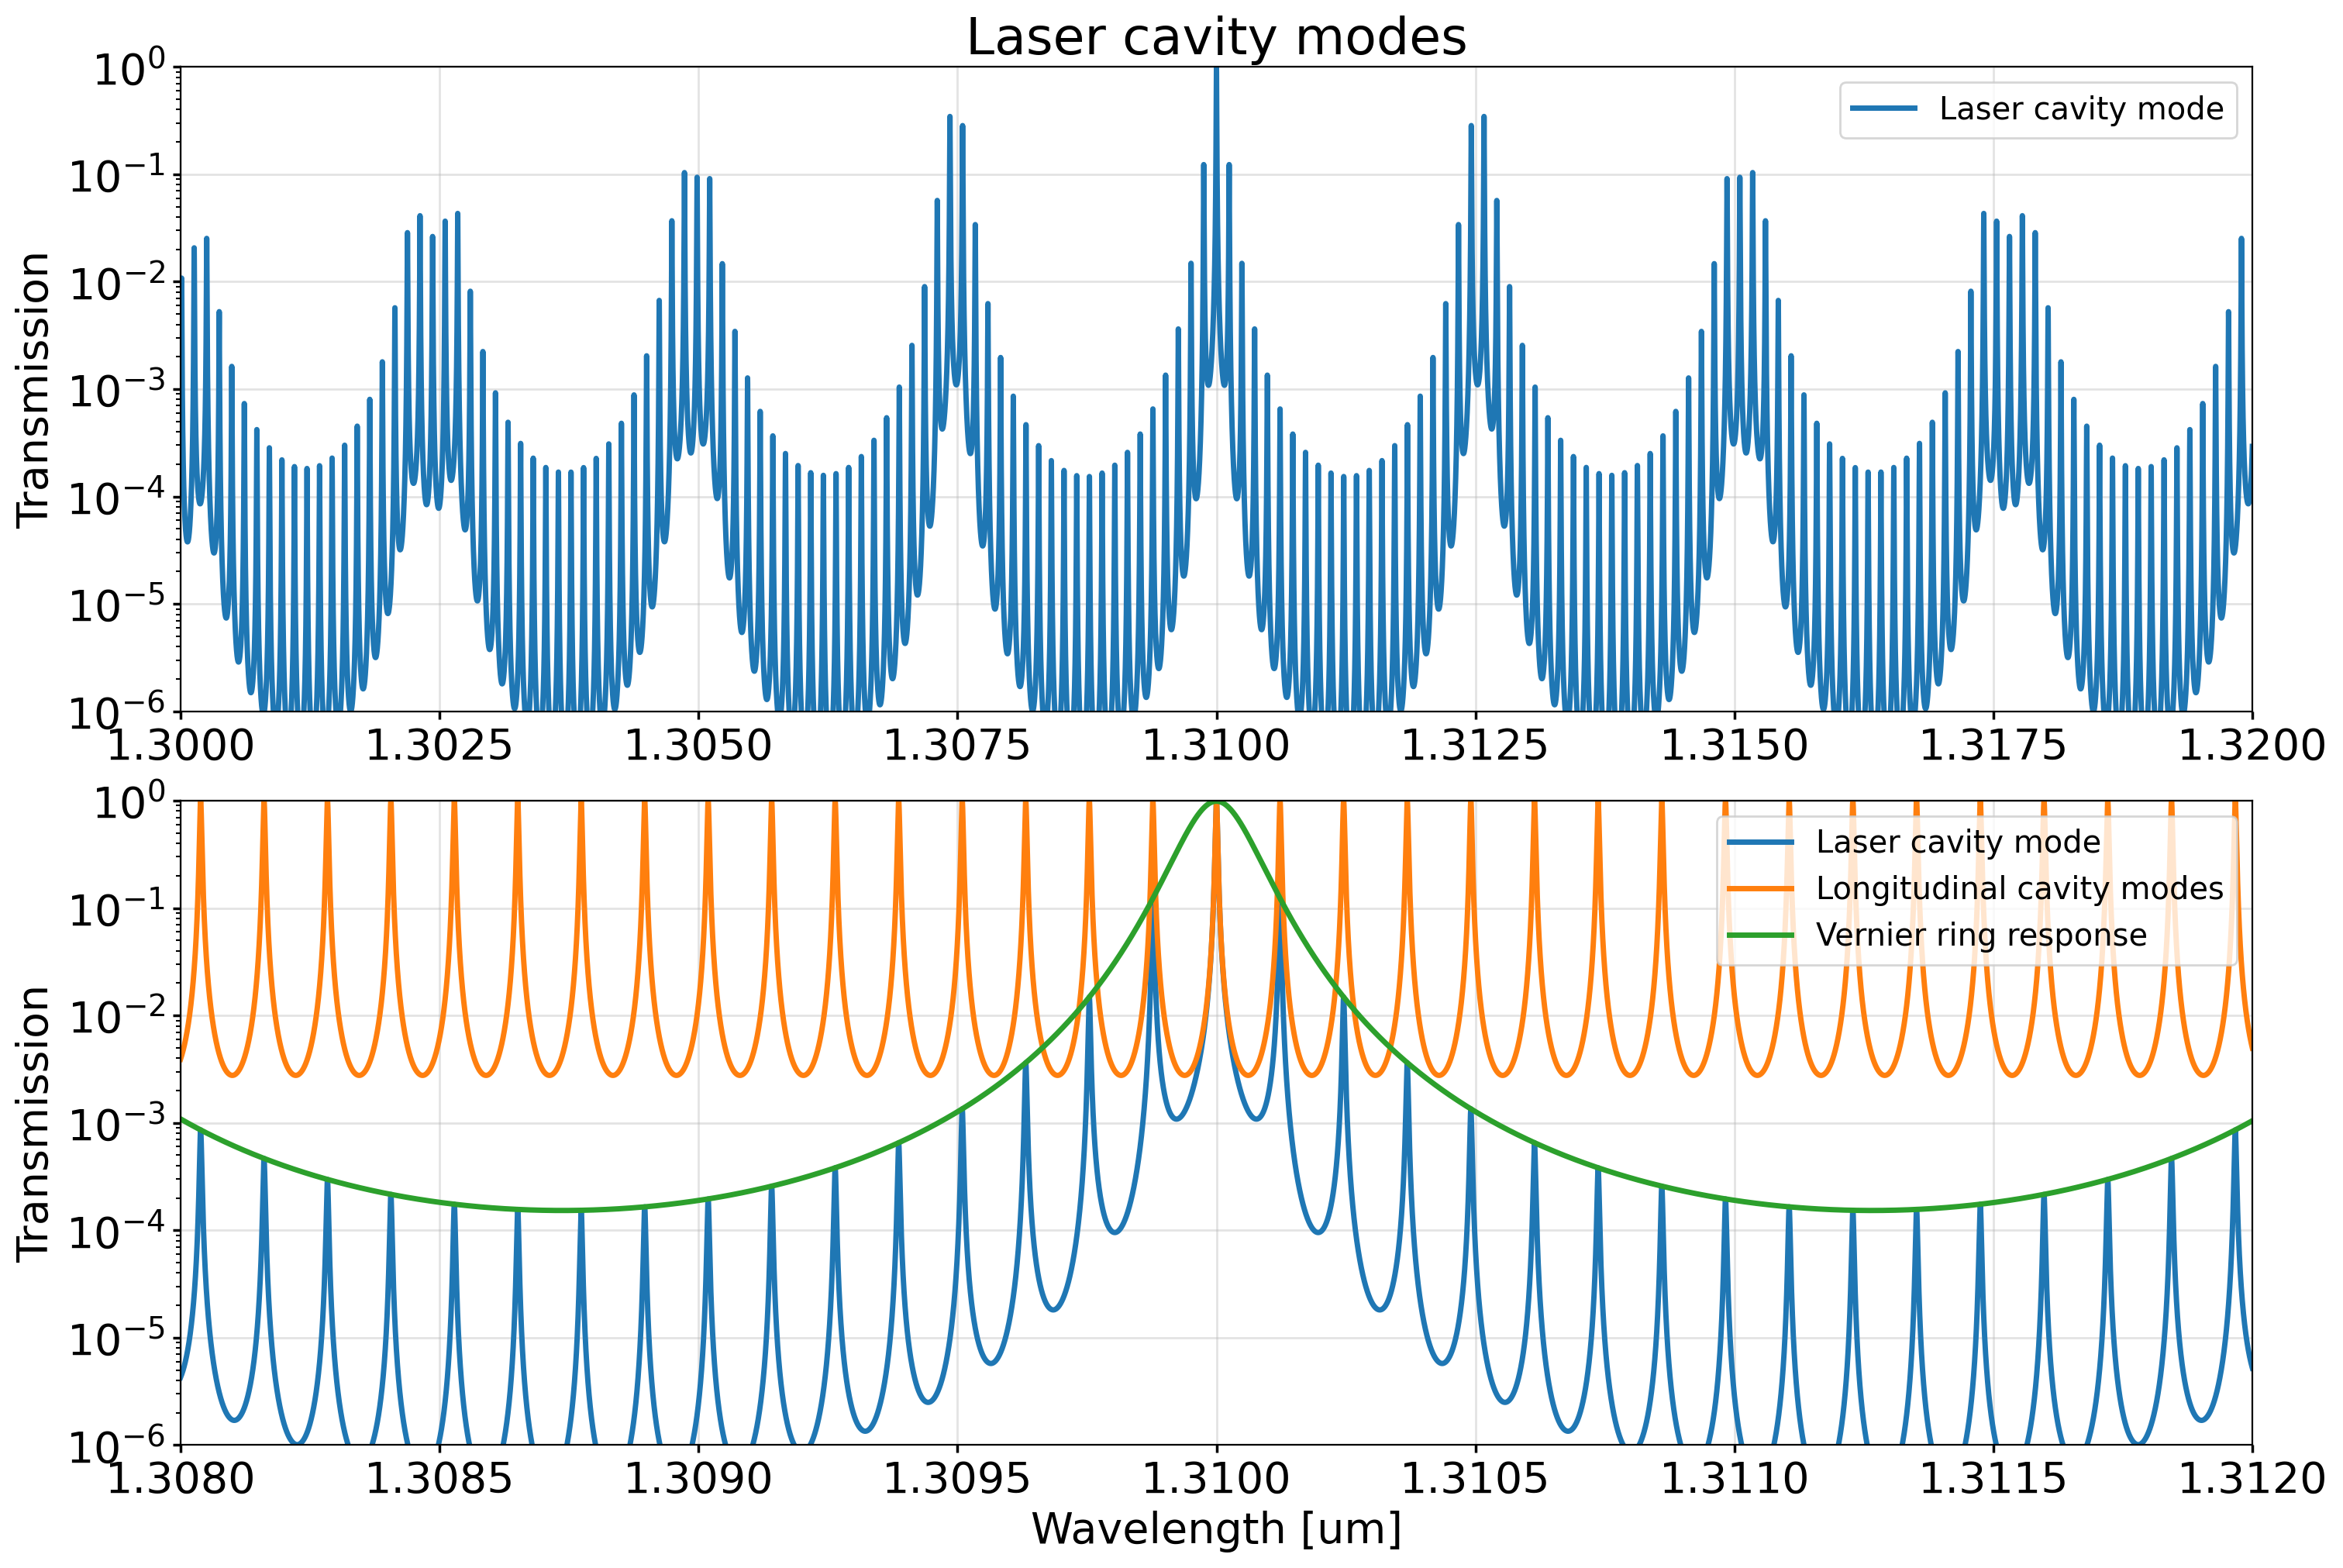

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.semilogy(wavelengths/um, laser_cavity_mode, label="Laser cavity mode")
plt.xlim([1.3, 1.32])
plt.ylim([1e-6,1])
plt.legend()
plt.ylabel("Transmission")
plt.title("Laser cavity modes")
plt.subplot(212)
plt.semilogy(wavelengths/um, laser_cavity_mode, label="Laser cavity mode")
plt.semilogy(wavelengths/um, lc_modes, label="Longitudinal cavity modes")
plt.semilogy(wavelengths/um, -1*np.array(vernier_response_tuned), label="Vernier ring response")
plt.xlim([1.308, 1.312])
plt.ylim([1e-6,1])
plt.legend()
plt.xlabel("Wavelength [um]")
plt.ylabel("Transmission")


## SOA analysis

In [11]:
L = np.array([440, 640, 840])
J = np.array([5, 7])
T = np.array([55, 65, 75, 85])
wavelengths_soa = np.linspace(1.27, 1.33, num=101) * um

g0_sweep = []
for length, current_density, temperature, wavelength in tqdm(product(L, J, T, wavelengths_soa), total=len(L)*len(J)*len(T)*len(wavelengths_soa)):
  _soa = SOA(
    temperature,
    current_density,
    length,
    wavelength *1e9
  )
  g0_sweep.append(_soa.g0)
g0_sweep = np.array(g0_sweep).reshape((len(L), len(J), len(T), len(wavelengths_soa)))

100%|██████████| 2424/2424 [00:00<00:00, 28227.69it/s]


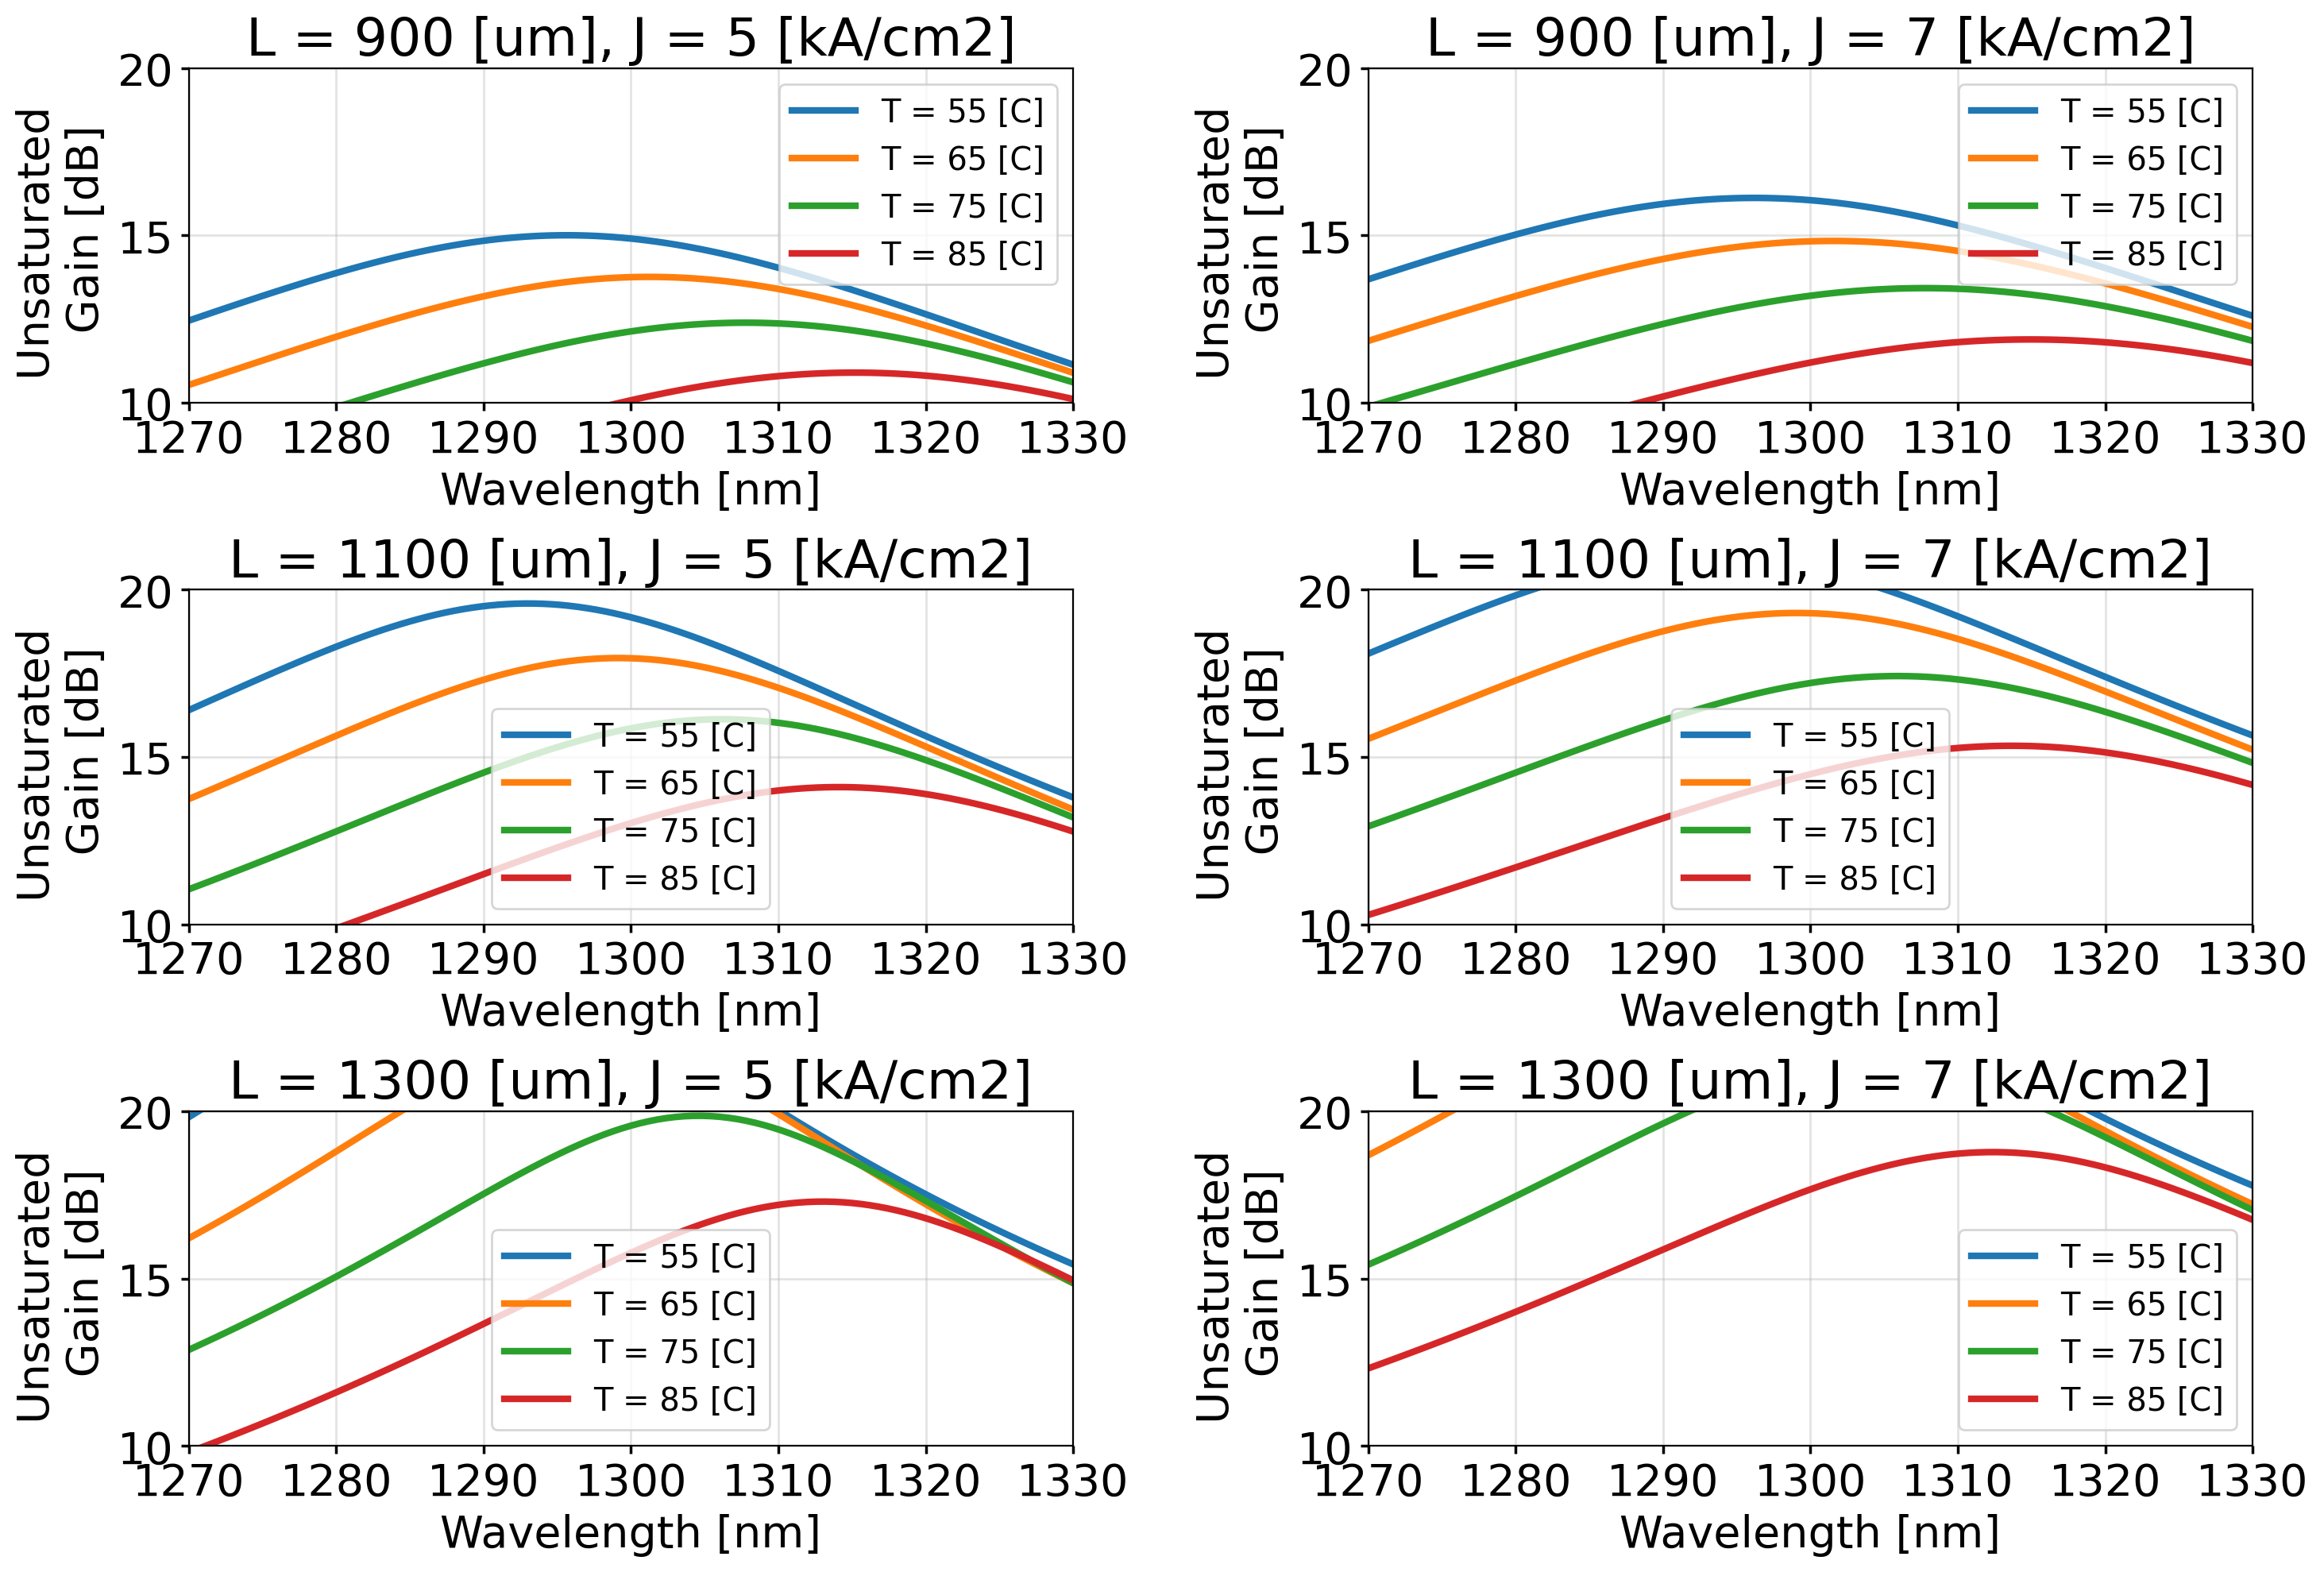

In [12]:
plt.figure(figsize=(15,10))
for idd_current_density, current_density in enumerate(J):
  for idd_length, length in enumerate(L):
    plt.subplot(len(L), len(J), idd_length*len(J)+idd_current_density+1)
    for idd_temperature, temperature in enumerate(T):  
      plt.plot(wavelengths_soa/um*1e3, 10*np.log10(g0_sweep[idd_length, idd_current_density, idd_temperature, :]), linewidth=3.0,label=f"T = {temperature} [C]")
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Unsaturated \n Gain [dB]")
    plt.title(f"L = {length + 460} [um], J = {current_density} [kA/cm2]")
    plt.grid(True)
    plt.xlim([1270, 1330])
    plt.ylim([10, 20])
    plt.grid(True)
    plt.legend()
plt.tight_layout()

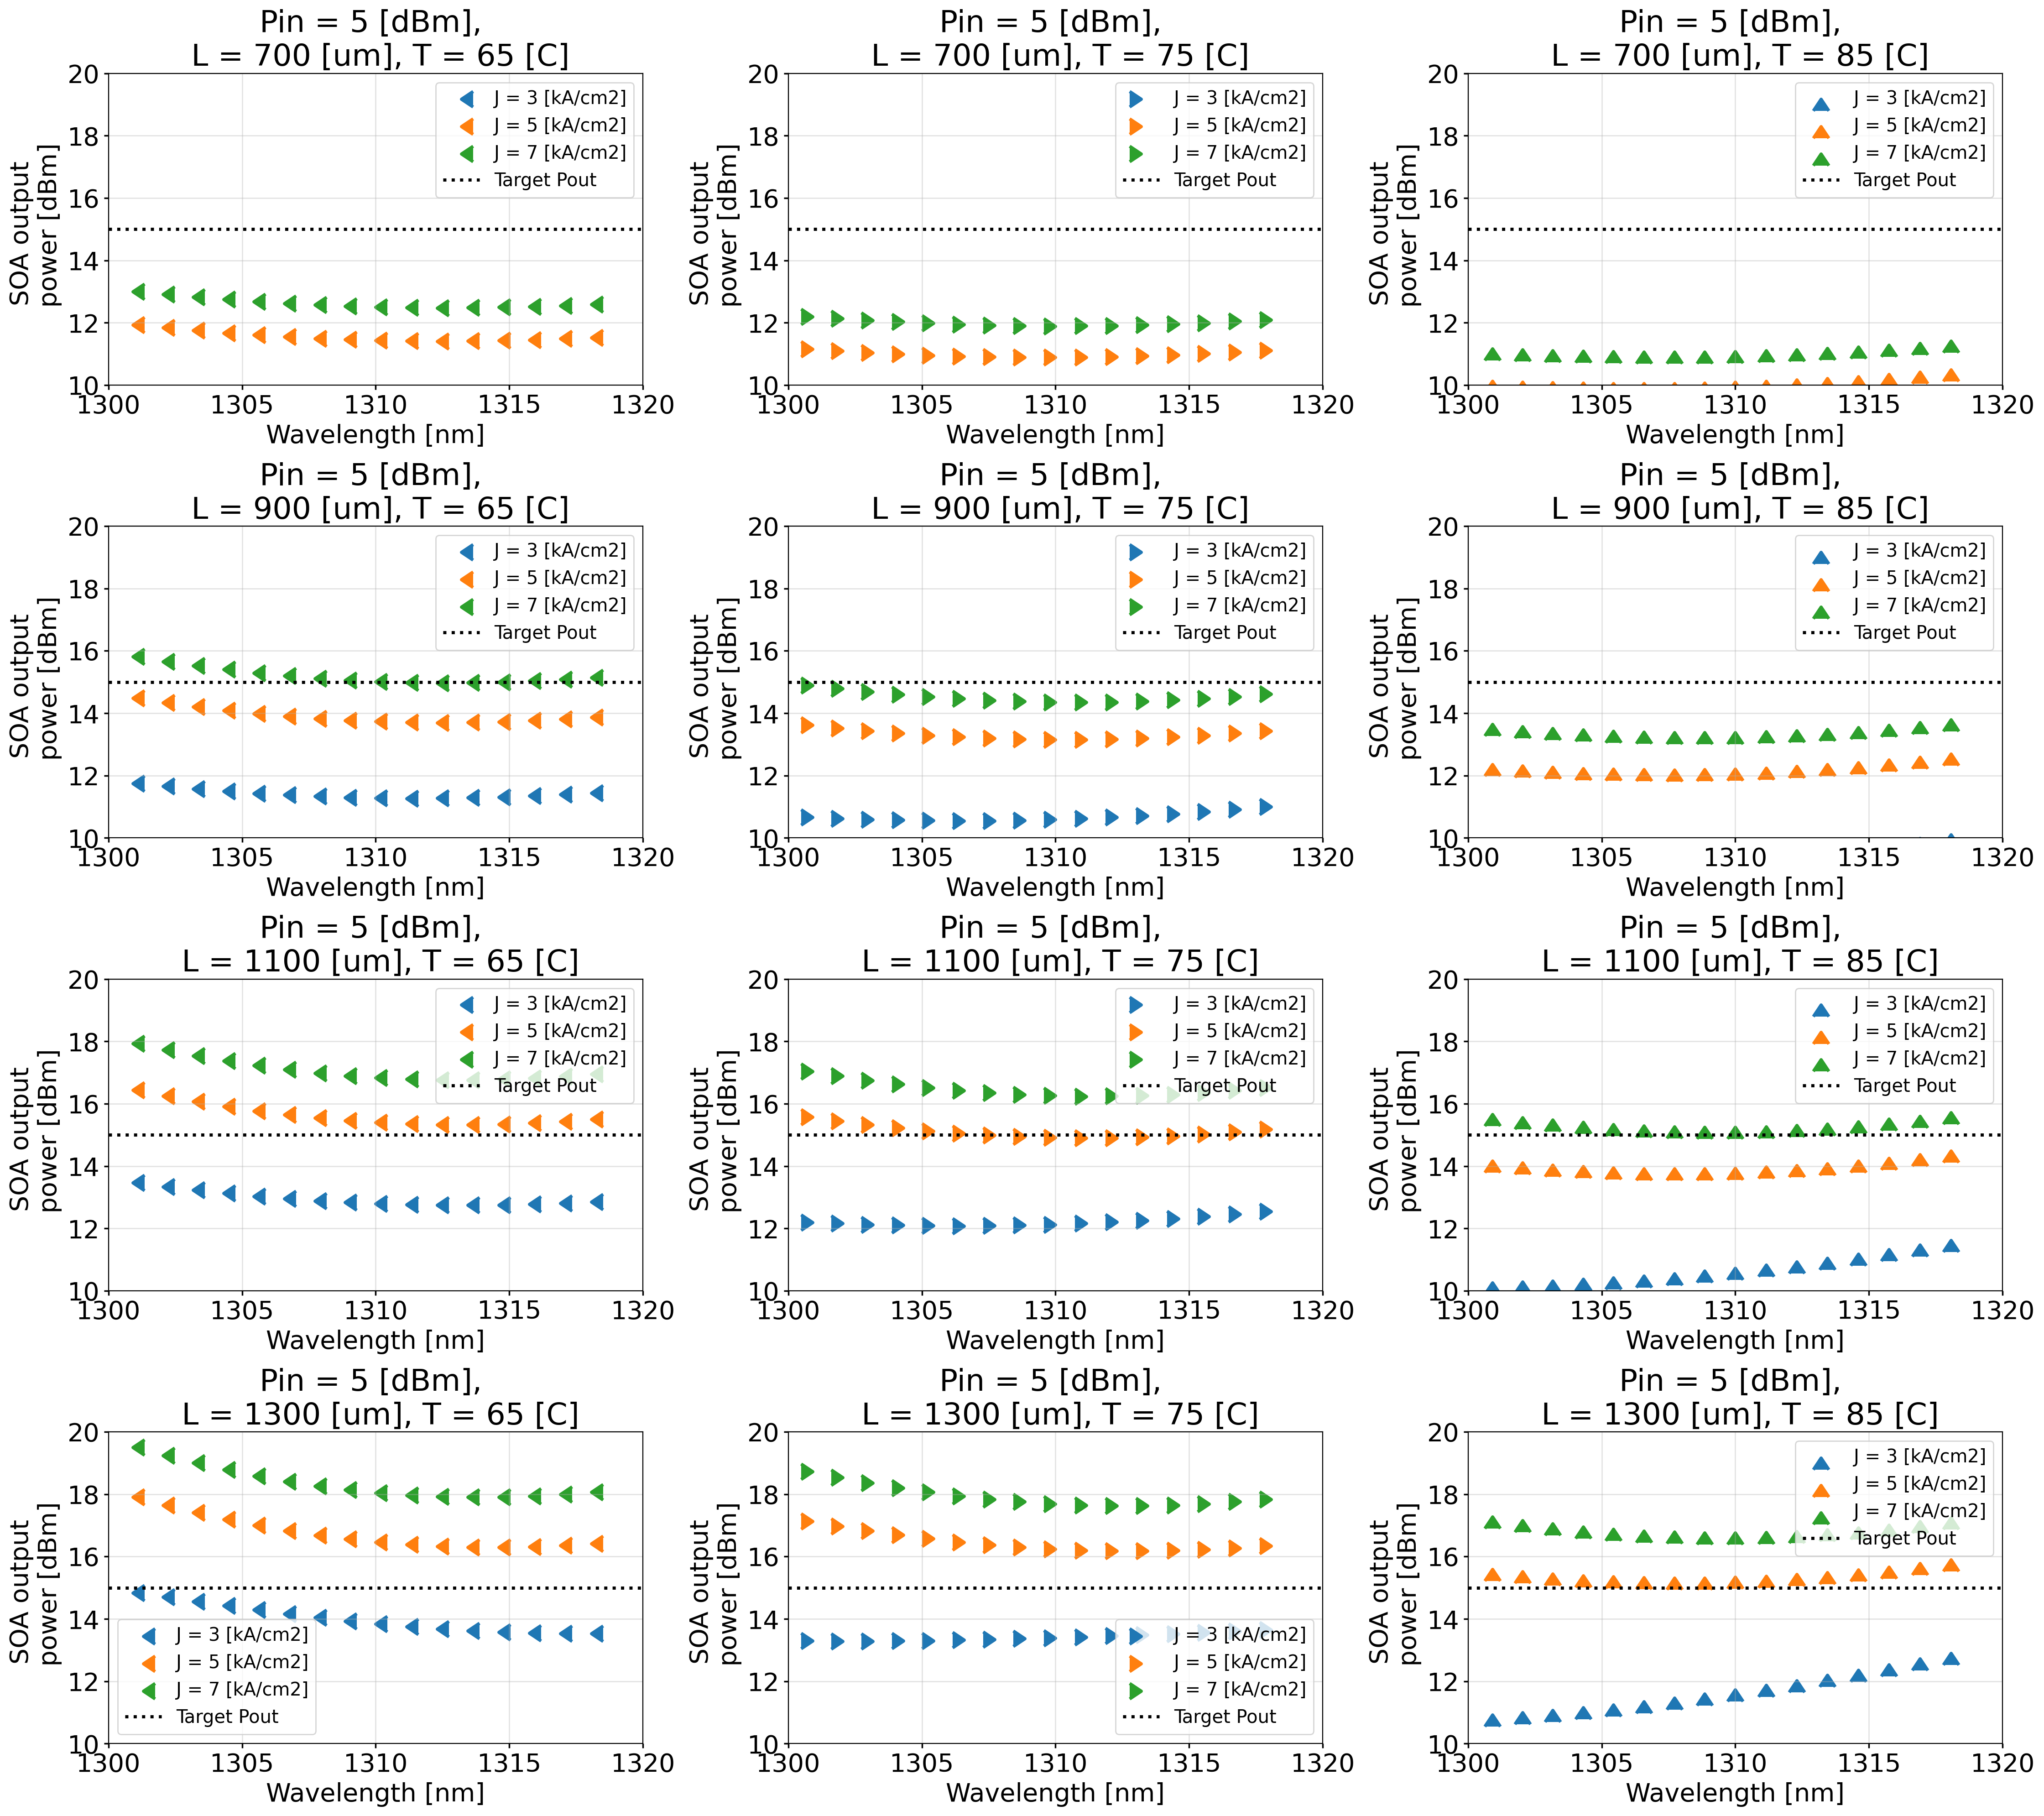

In [13]:
center_grid_wavelength = 1.31e-6
fsr = 400e9
grid_frequency_bank_A = [constants.c/center_grid_wavelength + i*fsr for i in range(-3, 5)]
grid_frequency_bank_B = [constants.c/center_grid_wavelength + (i-0.5)*fsr for i in range(-3, 5)]
grid_wavelength_bank_A = constants.c/np.array(grid_frequency_bank_A)
grid_wavelength_bank_B = constants.c/np.array(grid_frequency_bank_B) 

grid_wavelength_bank = np.sort(np.concatenate((grid_wavelength_bank_A, grid_wavelength_bank_B)))

L = np.array([240, 440, 640, 840])
J = np.array([3, 5,  7])
T = np.array([65, 75, 85])

Pin = 0.003

plt.figure(figsize=(7.5*len(T),5*len(L)))

for idd_length, length in enumerate(L):
  for idd_temperature, temperature in enumerate(T):
    for idd_current_density, current_density in enumerate(J):
      gain, Pout, Psat = [], [], []
      for wavelength in grid_wavelength_bank:
        _soa = SOA(
          T[idd_temperature],
          J[idd_current_density],
          L[idd_length],
          wavelength *1e9
        )
        gain.append(_soa.gain(Pin))
        Pout.append(10*np.log10(gain[-1])+10*np.log10(Pin)+30)
        Psat.append(_soa.Psat)

      plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
      plt.scatter(grid_wavelength_bank/um*1000, np.array(Pout), marker = idd_temperature + 4, s = 150, label=f"J = {current_density} [kA/cm2]")

    plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
    plt.plot(np.linspace(1300, 1320, num=100), np.ones(100)*15, linestyle=':', c='k', label="Target Pout")
    plt.legend()
    plt.xlim([1300, 1320])
    plt.xticks(np.arange(1300, 1325, 5))
    plt.ylim([10, 20])
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("SOA output \n power [dBm]")
    plt.title(f"Pin = 5 [dBm], \n L = {length + 460} [um], T = {temperature} [C]")
    plt.grid(True)
plt.tight_layout()


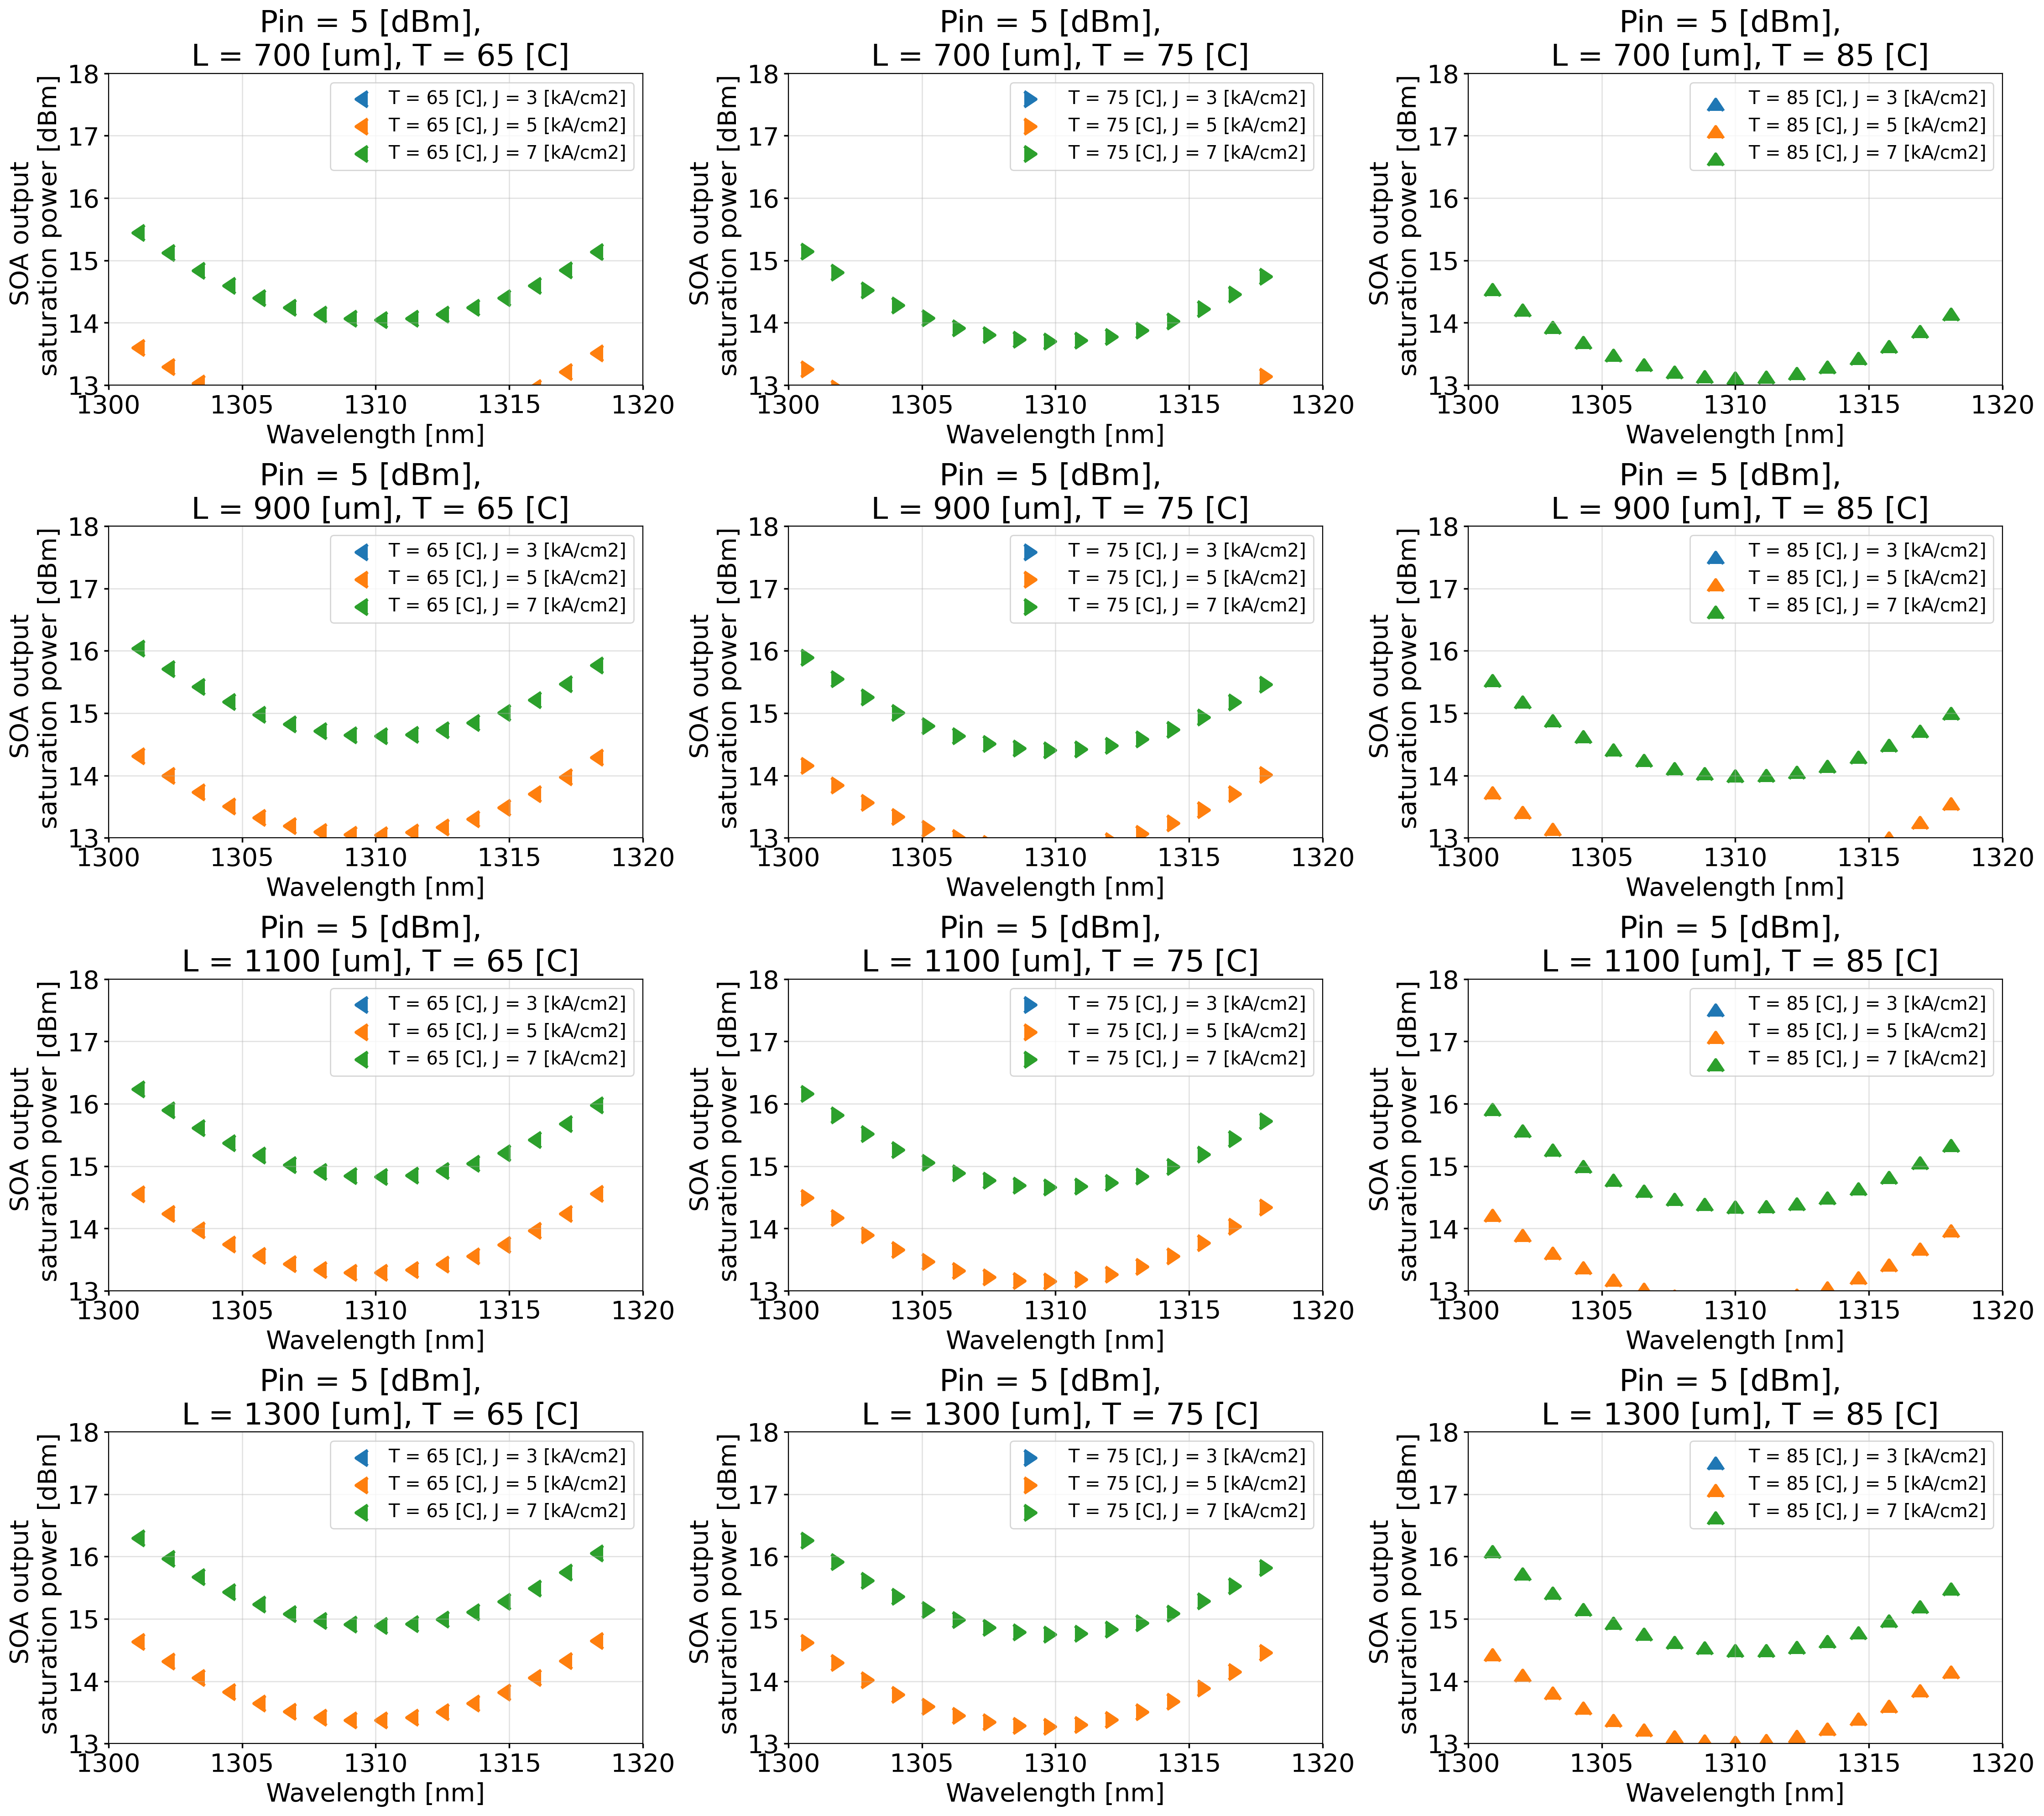

In [14]:
plt.figure(figsize=(7.5*len(T),5*len(L)))

for idd_length, length in enumerate(L):
  for idd_temperature, temperature in enumerate(T):
    for idd_current_density, current_density in enumerate(J):
      gain, Pout, Psat = [], [], []
      for wavelength in grid_wavelength_bank:
        _soa = SOA(
          T[idd_temperature],
          J[idd_current_density],
          L[idd_length],
          wavelength *1e9
        )
        gain.append(_soa.gain(Pin))
        Pout.append(10*np.log10(gain[-1])+10*np.log10(Pin)+30)
        Psat.append(_soa.Psat)

      plt.subplot(len(L),len(T),idd_length*len(T) + idd_temperature + 1)
      plt.scatter(grid_wavelength_bank/um*1000, 10*np.log10(np.array(Psat)/1e-3), marker = idd_temperature + 4, s = 150, label=f"T = {temperature} [C], J = {current_density} [kA/cm2]")
    plt.legend()
    plt.xlim([1300, 1320])
    plt.xticks(np.arange(1300, 1325, 5))
    plt.ylim([13, 18])
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("SOA output \n saturation power [dBm]")
    plt.title(f"Pin = 5 [dBm], \n L = {length + 460} [um], T = {temperature} [C]")
    plt.grid(True)
plt.tight_layout()


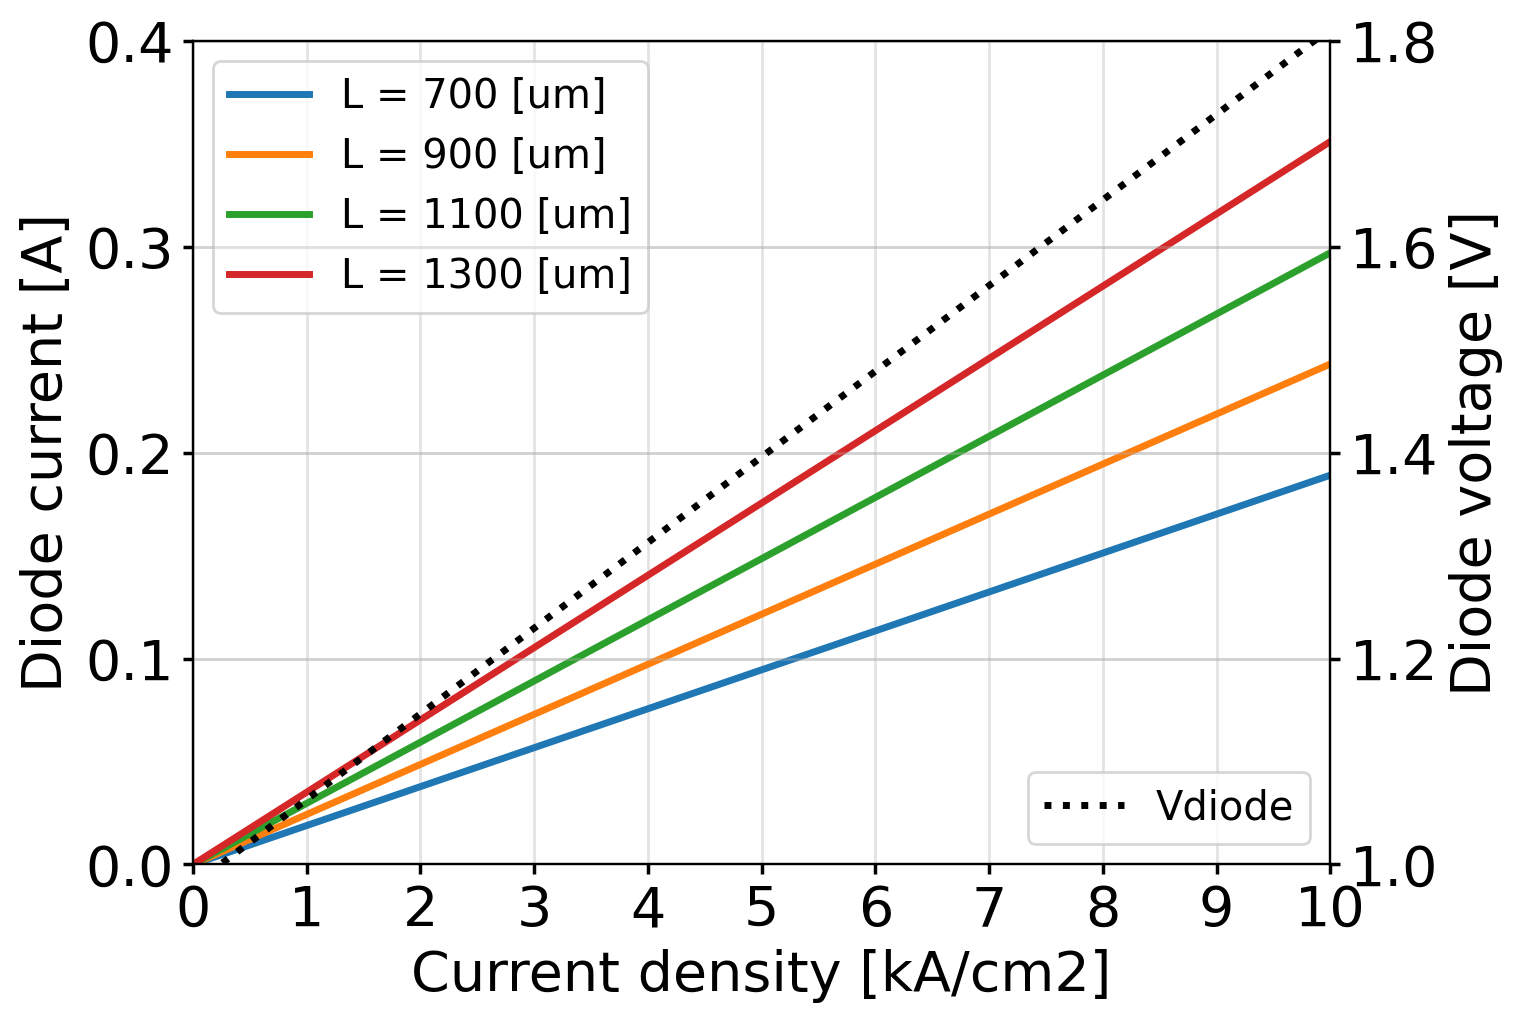

In [15]:
# Vdiode = 0.98 + 2.8*Idiode * (1100/L_SOA) 

def Vdiode(J, L_SOA, W=2.7):
  Idiode = J *1e3*  W * (L_SOA + 460) * 1e-8 # [A]
  return (0.98 + 2.8*Idiode * (1100/(L_SOA+460)), Idiode)

L = np.array([240, 440, 640, 840])
J = np.linspace(0, 10, num=101)

plt.figure(figsize=(7.5,5))
ax = plt.subplot(111)
for length in L:
  V, I = Vdiode(J, length)
  ax.plot(J, I, label=f"L = {length + 460} [um]")
plt.legend(loc=2)
ax2 = ax.twinx()

V, I = Vdiode(J, length)
ax2.plot(J, V, linestyle=':', c='k', label=f"Vdiode")
plt.legend(loc=4)
ax.set_xlabel("Current density [kA/cm2]")
ax.set_ylim([0,0.4])
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0, 11, 1))
ax.set_ylabel("Diode current [A]")
ax2.set_ylabel("Diode voltage [V]")
ax2.set_ylim([1.0,1.8])
ax2.set_xlim([0,10])
ax2.set_xticks(np.arange(0, 11, 1))
plt.grid(True)

## Openlight components

In [16]:
lm_cyclic_awg = pd.read_csv("lightmatter_cyclic.csv")
lm_cyclic_awg_reduced_wavelength = lm_cyclic_awg[(lm_cyclic_awg["Wavelength [nm]"] > 1300) & (lm_cyclic_awg["Wavelength [nm]"] < 1320)]

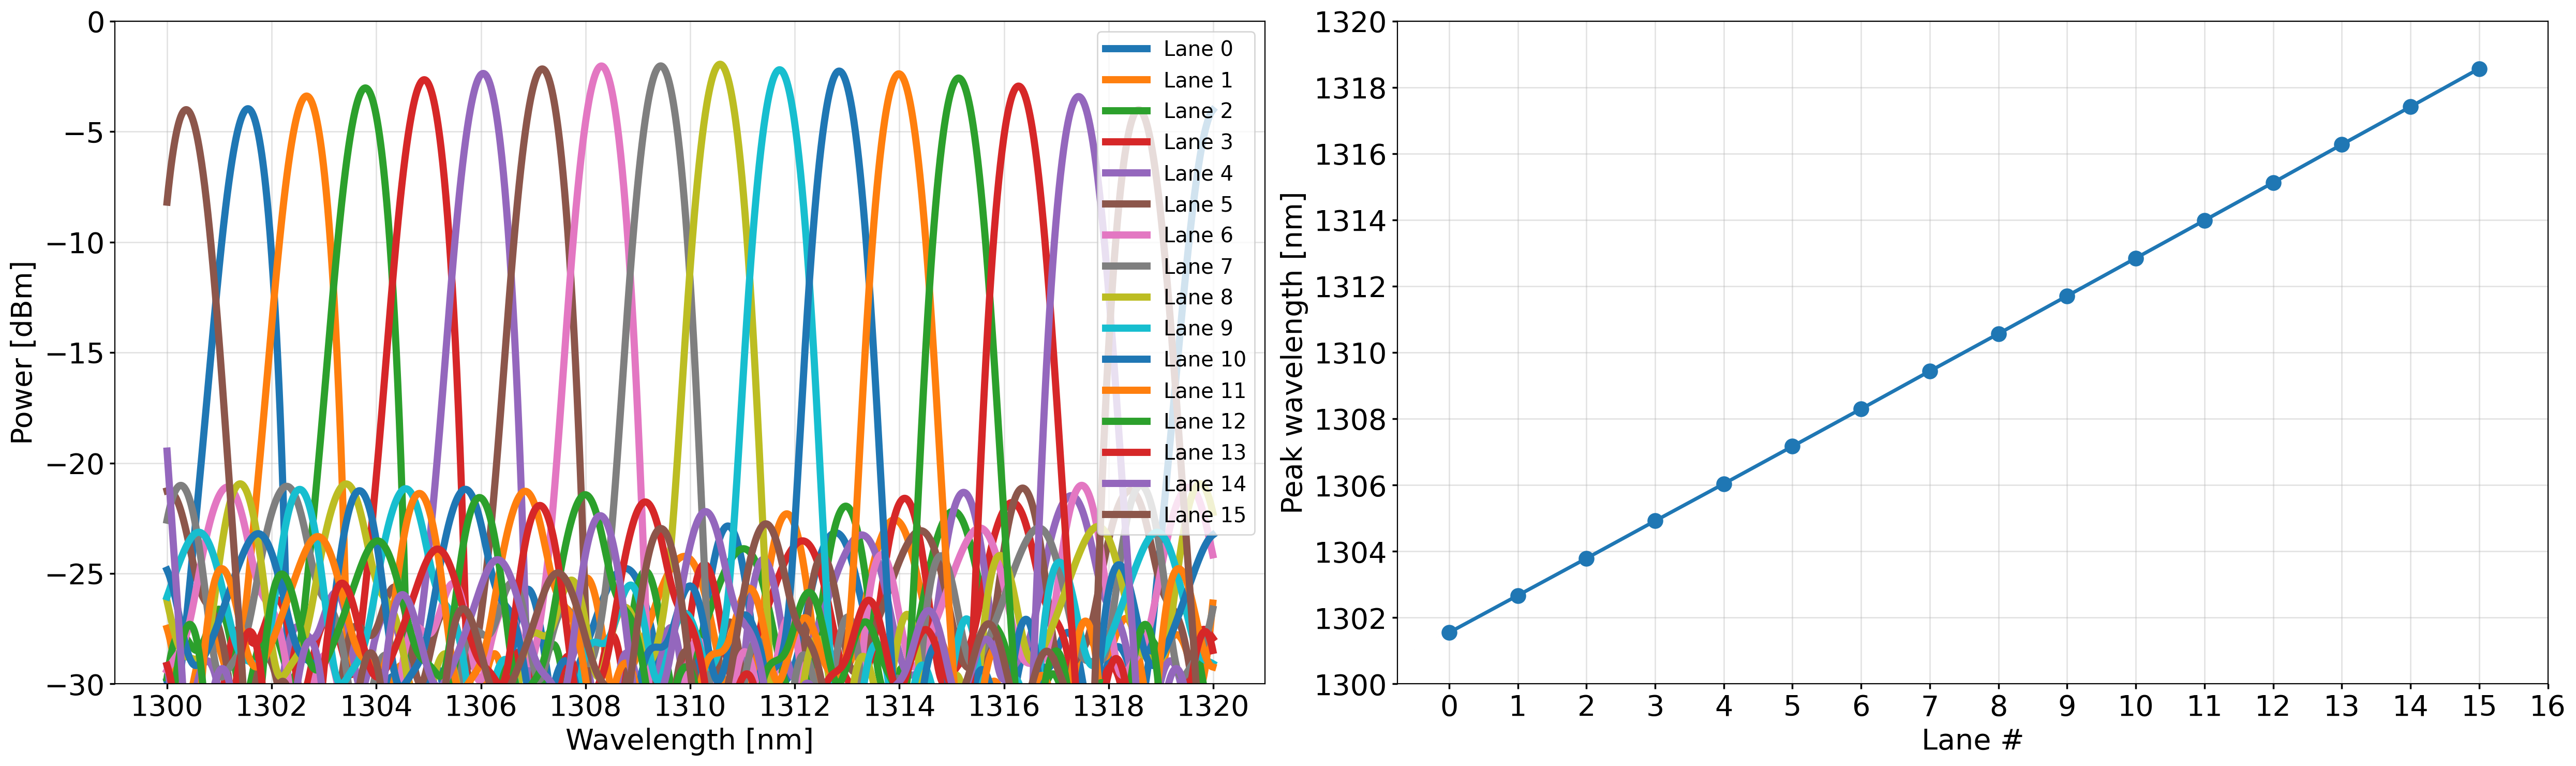

In [17]:
peak_wavelengths = []
plt.figure(figsize=(25,7.5))
plt.subplot(121)
for idd_lane, lane in enumerate(lm_cyclic_awg_reduced_wavelength['Lane'].unique()):
  lane_data = lm_cyclic_awg_reduced_wavelength[lm_cyclic_awg_reduced_wavelength['Lane'] == lane]
  arg_max = np.argmax(lane_data["Insertion Loss [dB]"])
  peak_wavelengths.append(lane_data["Wavelength [nm]"].values[arg_max])
  plt.plot(lane_data['Wavelength [nm]'], lane_data['Insertion Loss [dB]'], linewidth=5.0, label=f"Lane {lane}")
plt.legend()
plt.xticks(np.arange(1300, 1322, 2))
plt.ylim([-30, 0])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Power [dBm]")
plt.grid(True)
plt.subplot(122)
plt.plot(lm_cyclic_awg_reduced_wavelength['Lane'].unique(), peak_wavelengths, marker='o')
plt.xlabel("Lane #")
plt.ylabel("Peak wavelength [nm]")
plt.xticks(np.arange(0, 17, 1))
plt.ylim([1300, 1320])
plt.yticks(np.arange(1300, 1322, 2))
plt.tight_layout()


In [18]:
lm_2x2mmi = pd.read_csv("lm_sin_splitter_2x2mmi.csv")
list_to_pop = ['Insertion Loss (raw) @ Wavelength [dB]', 'Insertion Loss (smooth) @ Wavelength [dB]', 'Insertion Loss (raw) @ GCpk Wavelength [dB]', 'Insertion Loss (smooth) @ GCpk Wavelength [dB]', 'Cascade Number']
for _pop in list_to_pop:
  lm_2x2mmi.pop(_pop) 


In [19]:
_lm_2x2mmi = lm_2x2mmi[(lm_2x2mmi['Wavelength [nm]'] > 1299.9) & (lm_2x2mmi['Wavelength [nm]'] < 1320.1)]
_unique_wavelength, _unique_indices, _unique_inverse, _unique_counts = np.unique(_lm_2x2mmi['Wavelength [nm]'].values, return_counts=True, return_index=True, return_inverse=True)

for index in range(int(len(_lm_2x2mmi['Wavelength [nm]'].values)/len(_unique_wavelength))):
  _unique_ids = np.ones(len(_unique_wavelength), dtype=int) * index
  if index > 0:
    _ids = np.hstack((_ids, _unique_ids))
  else:
    _ids = _unique_ids

_lm_2x2mmi['_ids'] = _ids  

_lane_id = []
for _idd, _wavelength in enumerate(_lm_2x2mmi['Wavelength [nm]'].values):
  _lane_id.append(np.nan)
  for _idd_peak, _lane_peak_wavelength in enumerate(peak_wavelengths):
    if np.abs(_wavelength - _lane_peak_wavelength) == np.min(np.abs(_wavelength - peak_wavelengths)):
      _lane_id[-1] = _idd_peak
      break
  
_lm_2x2mmi['Lane'] = _lane_id
_lm_2x2mmi = _lm_2x2mmi.dropna()

([<matplotlib.axis.XTick at 0x297a5cb90>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '')])

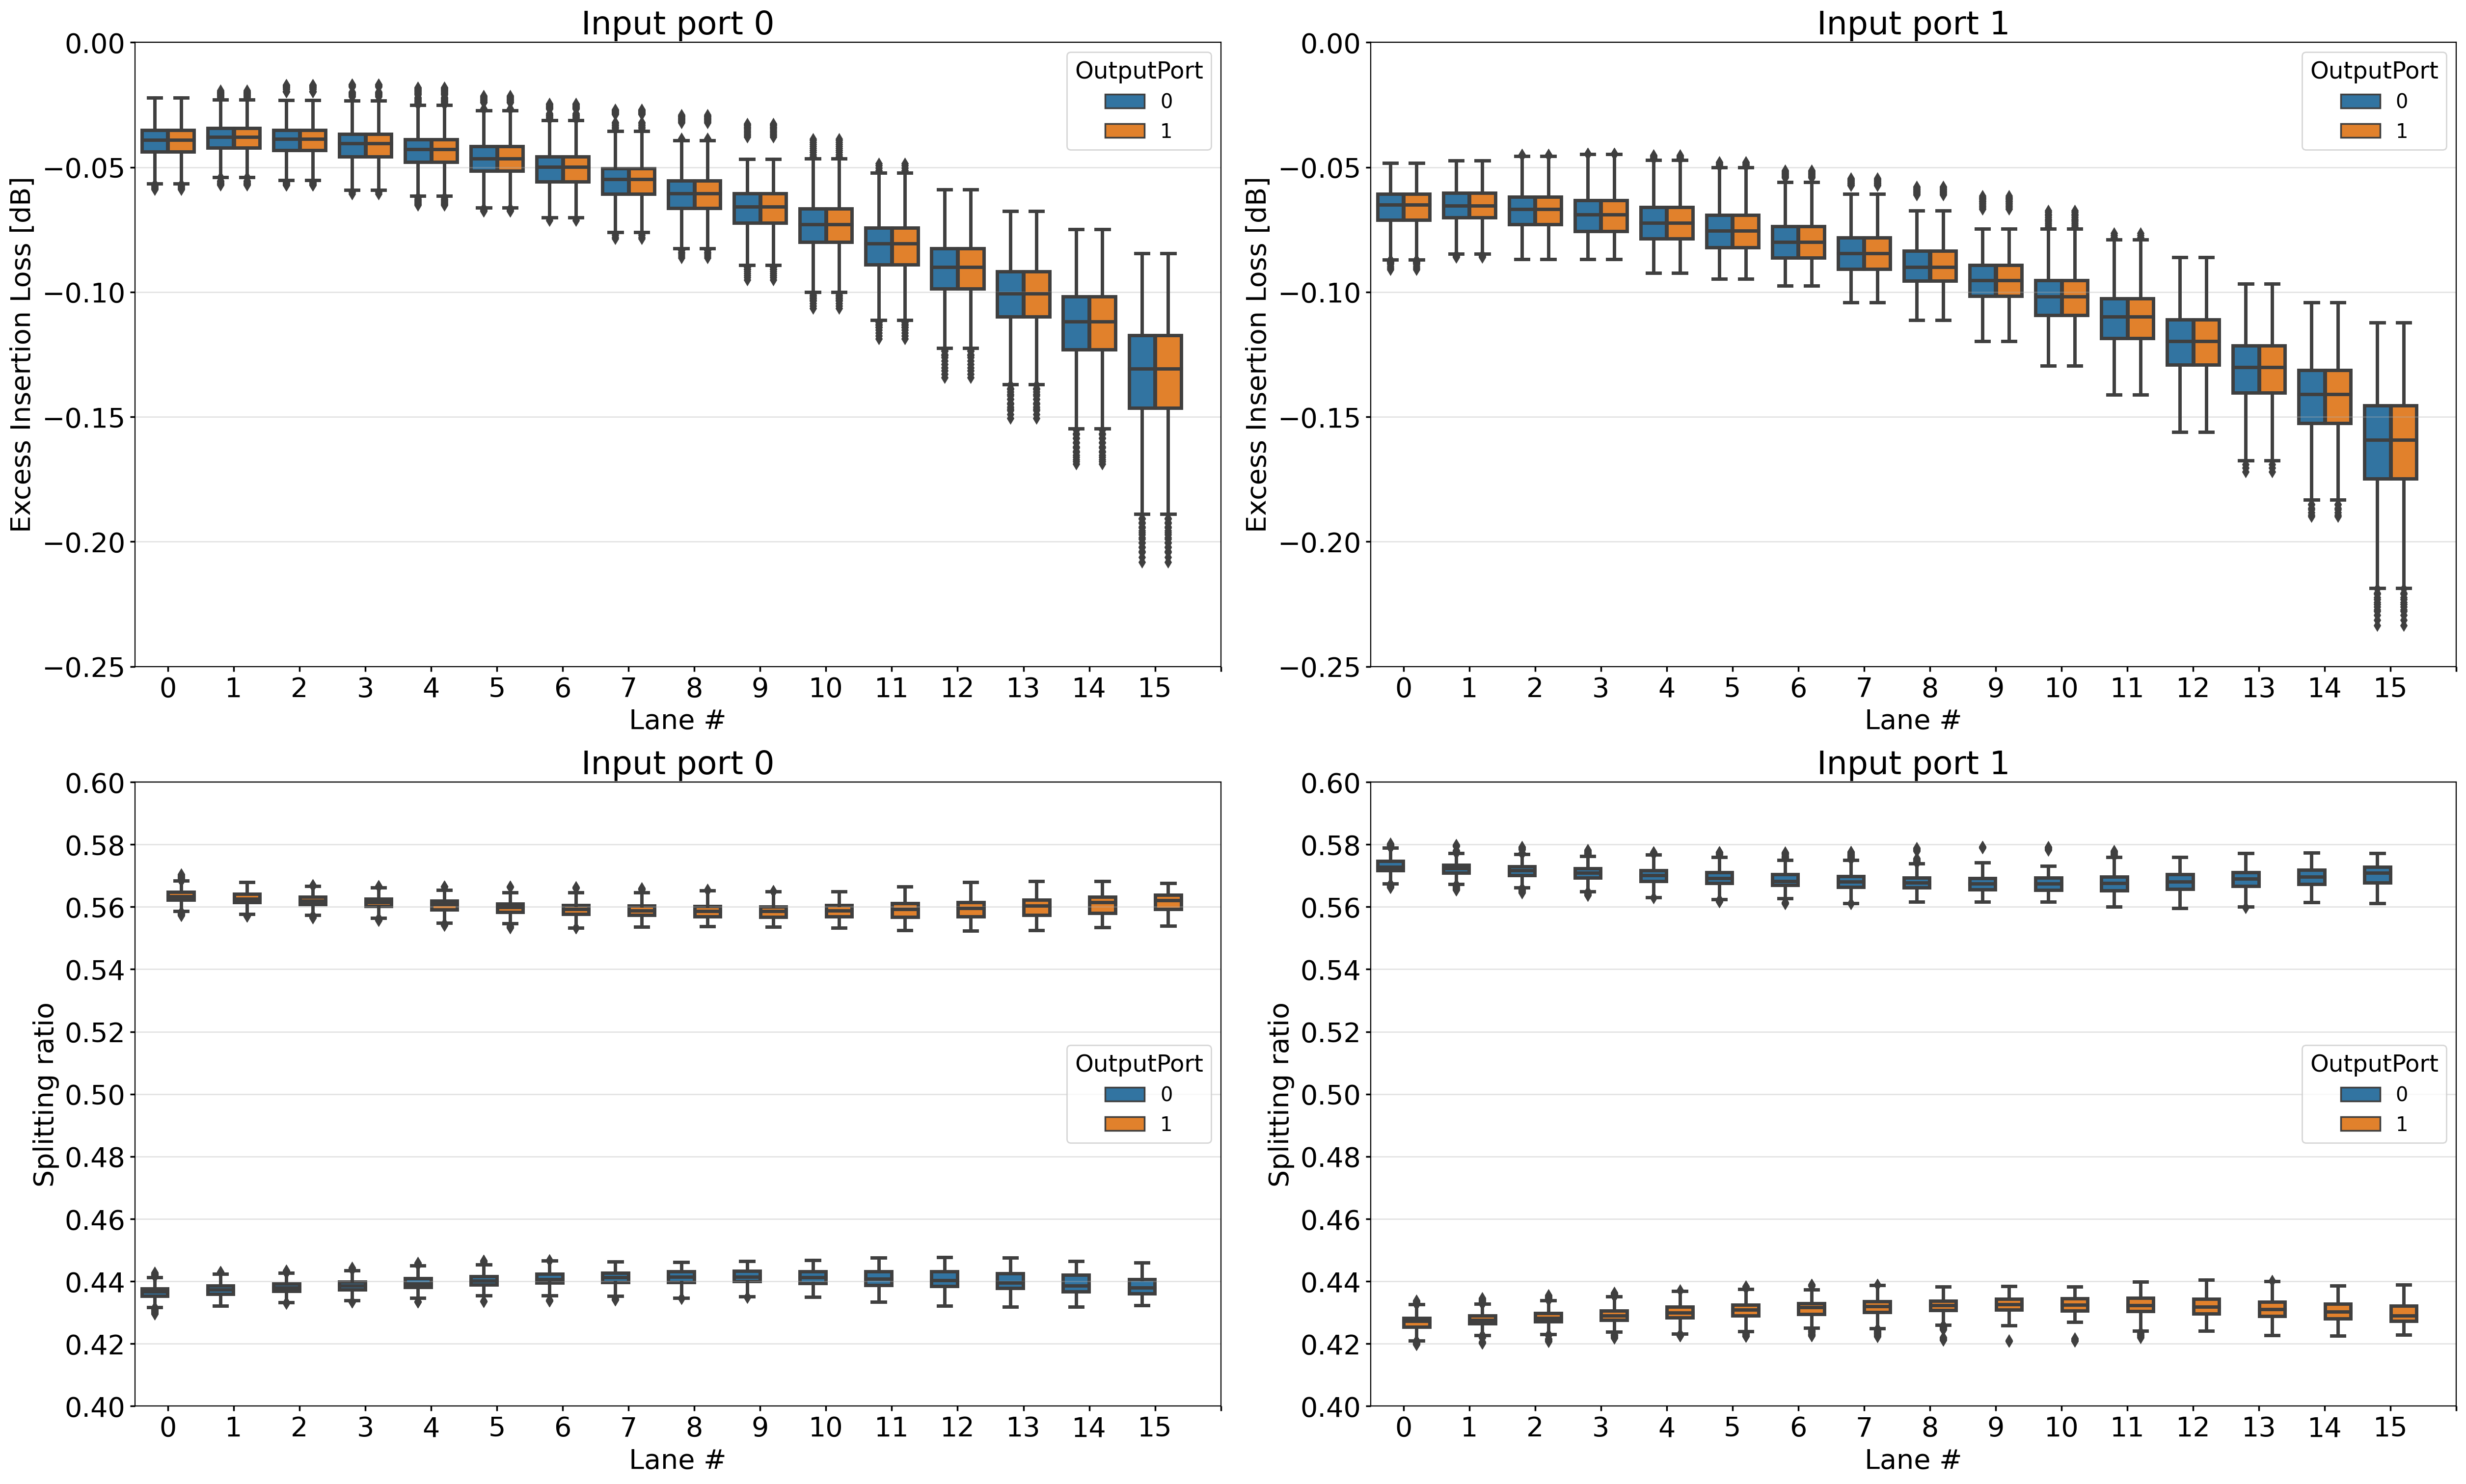

In [20]:
port_combinations = list(product([0, 1], [0, 1]))

plt.figure(figsize=(25,15))
plt.subplot(221)
_lm_2x2mmi_reduced = _lm_2x2mmi[(_lm_2x2mmi['InputPort'] == 0)]
sns.boxplot(data=_lm_2x2mmi_reduced, x='Lane', y='Total Insertion Loss (smooth) per DUT @ Wavelength [dB]', hue='OutputPort')
plt.title("Input port 0")
plt.xlabel("Lane #")
plt.ylabel("Excess Insertion Loss [dB]")
plt.yticks(np.arange(-0.25, 0.05, 0.05))
plt.xticks(np.arange(0, 17, 1))
plt.subplot(222)
_lm_2x2mmi_reduced = _lm_2x2mmi[(_lm_2x2mmi['InputPort'] == 1)]
sns.boxplot(data=_lm_2x2mmi_reduced, x='Lane', y='Total Insertion Loss (smooth) per DUT @ Wavelength [dB]', hue='OutputPort')
plt.xlabel("Lane #")
plt.ylabel("Excess Insertion Loss [dB]")
plt.title("Input port 1")
plt.yticks(np.arange(-0.25, 0.05, 0.05))
plt.xticks(np.arange(0, 17, 1))
plt.subplot(223)
_lm_2x2mmi_reduced = _lm_2x2mmi[(_lm_2x2mmi['InputPort'] == 0)]
sns.boxplot(data=_lm_2x2mmi_reduced, x='Lane', y='Split Ratio @ Wavelength', hue='OutputPort')
plt.title("Input port 0")
plt.xlabel("Lane #")
plt.ylabel("Splitting ratio")
plt.yticks(np.arange(0.4, 0.62, 0.02))
plt.xticks(np.arange(0, 17, 1))
plt.subplot(224)
_lm_2x2mmi_reduced = _lm_2x2mmi[(_lm_2x2mmi['InputPort'] == 1)]
sns.boxplot(data=_lm_2x2mmi_reduced, x='Lane', y='Split Ratio @ Wavelength', hue='OutputPort')
plt.xlabel("Lane #")
plt.ylabel("Splitting ratio")
plt.title("Input port 1")
plt.yticks(np.arange(0.4, 0.62, 0.02))
plt.xticks(np.arange(0, 17, 1))  